In [1]:
import os
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from scipy.stats import norm

from random_test_matrix import poly_decay, N_random_test_matrices, random_test_matrix
from randomized_svd import rsvd
from colors import colors3, colors5

np.random.seed(3145)

plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 15,
})

# Define common figure values
styles = ['-', '--', '-.']
markers = ['o', '^', '*']
sizes = [5, 6, 7]

In [2]:
def gamma(k, p, m, n) -> float:
    """
    Compute the coefficient for the expected error for RSVD.
    """
    return 1 + 4 * np.sqrt(k + p) / (p - 1) * np.sqrt(min(m, n))


def errors_rsvd_expected(singular_values, k_min, k_max, p) -> np.ndarray:
    """
    Compute the expected rSVD errors from the given spectral decay.
    """
    k_range = np.arange(k_min, k_max)
    n = len(singular_values)
    gammas = np.array([gamma(k, p, n, n) for k in k_range])
    return gammas * singular_values[k_min:k_max]


def errors_mean_ci(errors, nk, p=99):
    """
    Given errors of shape (3, r, nk), where r is the number of repeats and nk the
    number of k's, compute the mean and p% confidence intervals.
    """
    mean = errors.mean(axis=1)

    # Calculate p% confidence intervals
    std = errors.std(axis=1)
    z = norm.ppf((1 + p / 100) / 2)
    ci = z * std / np.sqrt(nk)
    return mean, ci

---
## Step 1: Spectral decay generation

In [3]:
def get_alpha(cond, n):
    """
    Get the alpha which gives the given condition number, assuming n.
    """
    return (np.sqrt(cond * (n - 1) ** 2) - n + 1) / (n - 1) ** 2


def get_sing_values(m, n, cond_numbers):
    """
    Get a the singular values associated with the given condition numbers.
    """
    ns = min(m, n)
    C, q = 10, 2  # Correct alphas only for q = 2
    alphas = [get_alpha(cond, ns) for cond in cond_numbers]
    sing_values = [poly_decay(ns, C, alpha, q) for alpha in alphas]
    return np.array(sing_values)

In [7]:
# Matrices of size (m, 5*m)
matrix_sizes = {
    "small": (100, 500),    # Small case
    "medium": (500, 2500),  # Medium case
    "large": (1000, 5000)   # Large case
}
cond_numbers = [
    2,            # Slow decay
    50,           # Moderate decay
    1000          # Rapid decay
]

# Generate the spectral decays
spectral_decays = {
    size: get_sing_values(m, n, cond_numbers)
    for size, (m, n) in matrix_sizes.items()
}
np.savez("../results/spectral_decays.npz", **spectral_decays)

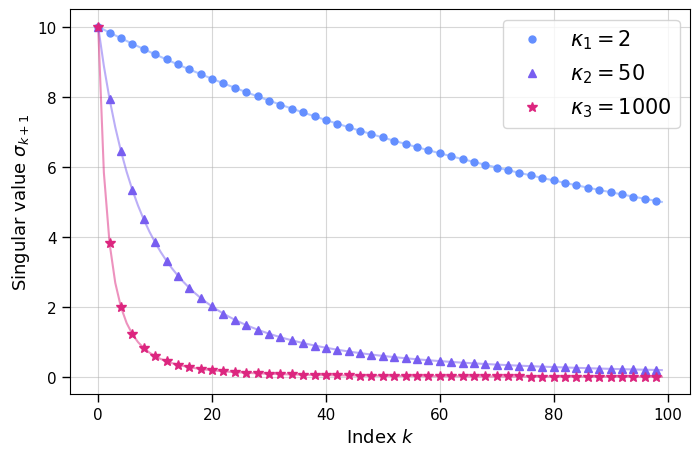

In [5]:
# Plot the spectral decays of the "Small case"
sing_values = spectral_decays["small"]
N = sing_values.shape[1]

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

step = 2
for i in range(3):
    ax.plot(
        np.arange(N)[::step], sing_values[i][::step], markers[i],
        c=colors3[i], ms=sizes[i], label=f'$\\kappa_{i+1}={cond_numbers[i]}$'
    )
    ax.plot(
        np.arange(N), sing_values[i], '-', c=colors3[i], ms=1, alpha=0.5
    )

ax.set_xlabel('Index $k$', fontsize=13)
ax.set_ylabel('Singular value $\\sigma_{k+1}$', fontsize=13)

ax.tick_params(axis='both', which='major', labelsize=11, length=6, width=1)
ax.tick_params(axis='both', which='minor', length=3, color='gray')

ax.grid(True, alpha=0.5)
ax.legend()
plt.show()


---
## Step 2: Test matrix generation

In [ ]:
# Number of repeats
repeats = {
    "small": 30,   # Small matrix (100x500)
    "medium": 10,  # Medium matrix (500x2500)
    "large": 5     # Large matrix (1000x5000)
}

file_path = "../data/"
for size, matrix_shape in matrix_sizes.items():  # ~ 10 min
    file_name = f"{size}.npy"
    m, n = matrix_shape
    R = repeats[size]
    
    # Each spectral decay case (slow, moderate, rapid).
    # This array has the shape (3, R, m, n), i.e. 3 cases (slow, moderate, rapid),
    # and R number of (m, n) arrays for each case.
    # Check if file already exists
    if os.path.exists(file_path + file_name):
        print(f"{file_name} already exists, skipping")
    else:
        print(f"Generating {file_name}: shape (3, {R}, {m}, {n})")
        # Singular values for given matrix shape
        sing_values = spectral_decays[size]
        data = [
            N_random_test_matrices(R, m, n, s)
            for s in sing_values
        ]
        np.save(file_path + file_name, data)

        # Files are very large
        del data

Generating small.npy: shape (3, 30, 100, 500)
Generating medium.npy: shape (3, 10, 500, 2500)
Generating large.npy: shape (3, 5, 1000, 5000)


In [7]:
# Load data
data_small = np.load(file_path + "small.npy")
data_medium = np.load(file_path + "medium.npy")
data_large = np.load(file_path + "large.npy")

print(
    f"data_small.shape  = {data_small.shape}\n"
    f"data_medium.shape = {data_medium.shape}\n"
    f"data_large.shape  = {data_large.shape}\n"
)

data_small.shape  = (3, 30, 100, 500)
data_medium.shape = (3, 10, 500, 2500)
data_large.shape  = (3, 5, 1000, 5000)



---
## Step 3: Run the experiments

In [ ]:
def progress_bar(step, total_steps, bar_length=30, fill='#', end_text=''):
    """
    Simple progress bar.
    """
    
    filled = int(bar_length * step / total_steps)
    text = f"[{filled * fill :<{bar_length}}] {step}/{total_steps}"
    end = '\r' if step < total_steps else '\n' 
    print(text + end_text, end=end)


def tsvd(A, k) -> tuple[np.ndarray, float]:
    """
    Get the rank-k truncated matrix Ak of a matrix A using SVD and the
    computation time of the factorization.
    """
    start = time.perf_counter()
    U, S, VT = sp.linalg.svd(A, full_matrices=False, lapack_driver="gesdd", check_finite=False)
    end =  time.perf_counter()
    return U[:, :k] @ np.diag(S[:k]) @ VT[:k, :], end - start


def trsvd(A, k, p) -> tuple[np.ndarray, float]:
    """
    Get the rank-k truncated matrix Ak of a matrix A using
    randomized SVD with oversampling parameter p and the computation time
    of the factorization.
    """
    start = time.perf_counter()
    Uk, Sk, VkT = rsvd(A, k, p)
    end =  time.perf_counter()
    return Uk @ np.diag(Sk) @ VkT, end - start


def experiment_rsvd(data, k_min, k_max, p=5, transpose=False):
    """
    Construct matrices with the given singular value distribution, and compute the l2
    errors of the rank-k approximation using randomized SVD with oversampling parameter p.
    """
    ns, nr, _, _ = data.shape  # (n spectral decays, n repeats, n, m)
    nk = k_max - k_min

    # The results are are gathered in arrays if shape (ns, nr, nk),
    # where ns is a given spectral decay (slow, moderate, rapid), nr are the 
    # repeats, and nk is the value for each rank-k experiment
    results_shape = (ns, nr, nk)
    times = np.zeros(results_shape)
    errors = np.zeros(results_shape)

    # Perform the experiments
    for s in range(ns):
        for r in range(nr):
            progress_bar(nr * s + r + 1, ns * nr)
            A = data[s, r, :, :]  # (m, n) matrix

            if transpose:
                A = A.T

            for i, k in enumerate(np.arange(k_min, k_max)):
                Ak, t = trsvd(A, k, p)

                # Error and time data
                times[s, r, i] = t
                errors[s, r, i] = np.linalg.norm(A - Ak, 2)
    return times, errors


def experiment_svd(data, transpose=False):
    """
    Construct matrices with the given singular value distribution, and compute the l2
    errors of the rank-k approximation using randomized SVD with oversampling parameter p.
    """
    ns, nr, _, _ = data.shape  # (n spectral decays, n repeats, n, m)

    # Compute the SVD for the 3 different spectral decays (ns), and
    # for the nr repeats given in the data. Computing for different rank-k
    # is not needed: the SVD is independent.
    times = np.zeros((ns, nr))

    # Perform the experiments
    for s in range(ns):
        for r in range(nr):
            progress_bar(nr * s + r + 1, ns * nr)
            A = data[s, r, :, :].copy()  # (m, n) matrix

            if transpose:
                A = A.T

            start = time.perf_counter()
            _ = sp.linalg.svd(A, full_matrices=False, lapack_driver="gesdd", check_finite=False)
            end =  time.perf_counter()

            times[s, r] = end - start
    return times


def experiment(data, k_min, k_max):
    # Experiments for rSVD
    t_rsvd, e = experiment_rsvd(data, k_min, k_max)
    t_rsvdT, eT = experiment_rsvd(data, k_min, k_max, transpose=True)

    # Experiments for SVD
    t_svd = experiment_svd(data)
    t_svdT = experiment_svd(data, transpose=True)
    
    results = {
        "t rsvd": t_rsvd,
        "t rsvdT": t_rsvdT,
        "t svd": t_svd,
        "t svdT": t_svdT,
        "e rsvd": e,
        "e rsvdT": eT
    }
    return results

In [ ]:
# Experiments for small case (100x500)
results_small = experiment(data_small, k_min=5, k_max=50)  # ~ 30 min

[##############################] 90/90
[##############################] 90/90
[##############################] 90/90
[##############################] 90/90


In [ ]:
# Experiments for medium case (500x2500)
results_medium = experiment(data_medium, k_min=5, k_max=50)  # ~ 30 min

[##############################] 30/30
[##############################] 30/30
[##############################] 30/30
[##############################] 30/30


In [ ]:
# Experiments for large case (1000x5000)
results_large = experiment(data_large, k_min=5, k_max=50)  # ~ 1 hr

[##############################] 15/15
[##############################] 15/15
[##############################] 15/15
[##############################] 15/15


In [37]:
results = {
    'small': results_small,
    'medium': results_medium,
    'large': results_large
}

# Add spectral decay data to the results
for size, sing_vals in spectral_decays.items():
    results['singular vals'] = sing_vals

# Save to disk
results_path = "../results/"
for size, sing_vals in spectral_decays.items():
    file_name = f"results_{size}.npz"
    if os.path.exists(results_path + file_name):
        print(file_name, "already exits, skipping")
    else:
        print(file_name, "saved in", results_path)
        np.savez(results_path + file_name, **results[size])


results_small.npz already exits, skipping
results_medium.npz already exits, skipping
results_large.npz already exits, skipping


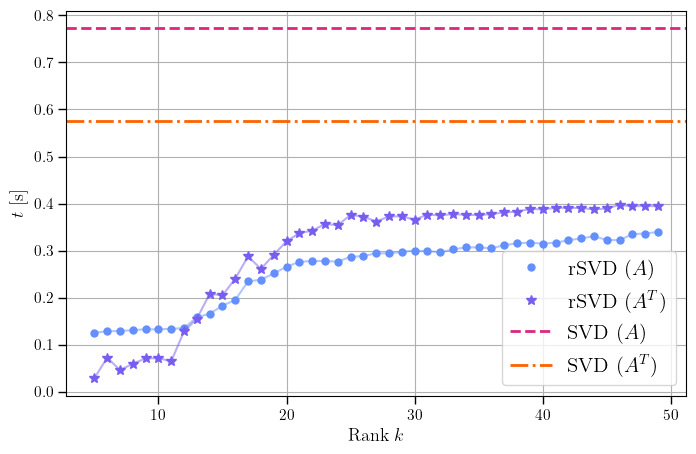

In [24]:
plot_results(results_medium)

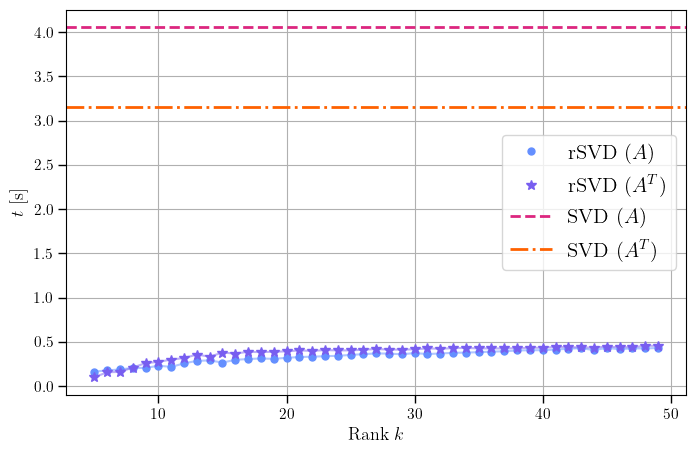

In [25]:
plot_results(results_large)

In [ ]:
mean, ci = errors_mean_ci(errors, k_max-k_min, p=99)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

for i in range(3):
    ax.plot(k_range, mean[i], markers[i], c=colors3[i], ms=sizes[i],
            label=f'$\\alpha_{i}={alphas[i]}$')
    ax.plot(k_range, expected_errors[i], c=colors3[i], ls=styles[i])
    #ax.plot(k_range, mean_error, color=colors3[i], lw=2, alpha=0.5)
    ax.fill_between(k_range, mean[i] - ci[i], mean[i]+ ci[i], color=colors3[i], alpha=0.2)


ax.set_ylim(-1, 20)
ax.set_xlabel('Rank $k$')
ax.set_ylabel('$\\ell_2$ operator error')
ax.set_title('Reconstruction errors')
ax.legend()
ax.grid(True, alpha=0.5)
plt.show()

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

k_range = np.arange(k_min, k_max)

for i in range(3):
    ax = axs[i]
    ax.plot(k_range, mean[i], markers[i], c=colors3[i], ms=sizes[i], label=f'Case {i + 1}')
    ax.plot(k_range, expected_errors[i], c=colors3[i])
    ax.fill_between(k_range, mean[i] - ci[i], mean[i]+ ci[i], color=colors3[i], alpha=0.25)

    ax.grid(True, alpha=0.5)
    ax.legend(loc='upper right')

axs[0].set_title("Reconstruction error and expected error", fontsize=16)
axs[1].set_ylabel('$\\ell_2$ error', fontsize=13)
axs[2].set_xlabel("Rank $k$", fontsize=13)

plt.show()

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

k_range = np.arange(k_min, k_max)

for i in range(3):
    ax = axs[i]
    ax.plot(k_range, mean[i], markers[i], c=colors3[i], ms=sizes[i], label=f'Case {i + 1}')  # RSVD error
    ax.plot(k_range, Ss[i][k_range], c=colors3[i])  # SVD error
    ax.fill_between(k_range, mean[i] - ci[i], mean[i]+ ci[i], color=colors3[i], alpha=0.25)
    ax.grid(True, alpha=0.5)
    ax.legend()

axs[0].set_title("RSVD vs SVD: Operator error across $k$", fontsize=16)
axs[1].set_ylabel('$\\ell_2$ error', fontsize=13)
axs[2].set_xlabel("Rank $k$", fontsize=13)

plt.show()